Same as micrograd.py, but uses PyTorch for the autograd engine.
This is a way for us to check and verify correctness, and also
shows some of the similarities/differences in how PyTorch would
implement the same MLP. PyTorch lets you specify the forward pass,
records all the operations performed, and then calls backward()
"under the hood" inside its autograd engine.

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter

torch.manual_seed(1)

from utils import gen_data_yinyang

In [9]:
# -----------------------------------------------------------------------------
# Multi-Layer Perceptron (MLP) network

class Neuron(nn.Module):

    # Neuron Creation
    def __init__(self, nin, nonlin=True):

        # compability, class inheritance related
        super().__init__() 
        
        # PARAMETERS: 

        # weights
        # so the random weight initialization is rescaled by a factor depending on the input number. This leads 
        # to smaller weight initializations for a higher number of nin. 
        # "All the weights and biases are initialized from..."  see: torch.nn.LSTM.html
        self.w = Parameter(torch.tensor([random.uniform(-1, 1) * nin**-0.5 for _ in range(nin)]))
        
        # biases
        # all bias scalars are initialized with 0
        self.b = Parameter(torch.zeros(1))

        # all neurons have a nonlinear output activation by default, except otherwise indicated
        self.nonlin = nonlin

    # Neuron Activation:
    def forward(self, x):
        # act = (w1*x1 + w2*x2 + ... + wnin*xnin) + b
        act = torch.sum(self.w * x) + self.b

        # o = tanh(act)
        return act.tanh() if self.nonlin else act

    def __repr__(self):
        return f"{'TanH' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(nn.Module):

    # Layer Creation
    def __init__(self, nin, nout, **kwargs):

        super().__init__() # compatibility

        # create a layer as a list of {nout} neurons with each neuron having {nin} inputs
        self.neurons = nn.ModuleList([Neuron(nin, **kwargs) for _ in range(nout)])

    # Layer Activation by rearranging the calculated activations of the corresponding neurons
    # to a stacked tensor (concatenated)
    def forward(self, x):
        out = [n(x) for n in self.neurons]
        return torch.stack(out, dim=-1)

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(nn.Module):

    # Create a Multilayer Perceptron Network
    def __init__(self, nin, nouts):     # ex.: NN = MLP(2,[4,4,1])

        # compatibility
        super().__init__() 

        # network dimensions as a list of [nin, layer1_neurons, layer2_neurons, layer..., nout]
        # [2,4,4,1] --> 2 hidden layers, 8 hidden neurons, 1 output neuron
        sz = [nin] + nouts

        # according to the given dimensions, create the layers, so [2,,4] , [4,4], [4,1]
        # Note: unlike in the hidden layers, the neurons in the output layer are linear
        self.layers = nn.ModuleList([Layer(sz[i], sz[i+1], nonlin = (i != len(nouts)-1)) for i in range(len(nouts))])

    # Activation of the complete Network (Forward Propagation), by subsequently activating each layer
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x    # return a set of layer activations

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

# -----------------------------------------------------------------------------

let's train!

In [10]:
# generate a dataset with 100 2-dimensional datapoints in 3 classes
train_split, val_split, test_split = gen_data_yinyang(random, n=100) # split ratios 80/10/10

In [11]:
# init the model: 2D inputs, 8 neurons, 3 outputs (logits)
model = MLP(2, [16, 16, 8 , 3])
model.to(torch.float64) # ensure we're using double precision
model

MLP of [Layer of [TanHNeuron(2), TanHNeuron(2), TanHNeuron(2), TanHNeuron(2), TanHNeuron(2), TanHNeuron(2), TanHNeuron(2), TanHNeuron(2), TanHNeuron(2), TanHNeuron(2), TanHNeuron(2), TanHNeuron(2), TanHNeuron(2), TanHNeuron(2), TanHNeuron(2), TanHNeuron(2)], Layer of [TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16)], Layer of [TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16), TanHNeuron(16)], Layer of [LinearNeuron(8), LinearNeuron(8), LinearNeuron(8)]]

In [12]:
# optimize using Adam
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-1,
    betas=(0.9, 0.95),
    eps=1e-8,
    weight_decay=1e-4
)

In [13]:
def loss_fun(model, split):
    losses = [F.cross_entropy(model(torch.tensor(x)), torch.tensor(y).view(-1)) for x, y in split]
    return torch.stack(losses).mean()

In [14]:
# train the network
train_losses, val_losses, val_steps = ([],[],[])

num_steps = 100
for step in range(num_steps):

    # evaluate the validation split every few steps
    if step % 10 == 0 or step == num_steps-1:
        val_loss = loss_fun(model, val_split)
        print(f"step {step+1}/{num_steps}, val loss {val_loss.item()}")
        val_losses.append(val_loss.item())
        val_steps.append(step)

    # forward the network and the loss and all training datapoints
    loss = loss_fun(model, train_split)
    # backward pass (calculate the gradient of the loss w.r.t. the model parameters)
    loss.backward()
    # update model parameters
    optimizer.step()
    optimizer.zero_grad()
    # print some stats
    print(f"step {step+1}/{num_steps}, train loss {loss.item()}")
    train_losses.append(loss.data)

step 1/100, val loss 1.2021295849238443
step 1/100, train loss 1.1610096575306714
step 2/100, train loss 0.9392739481405477
step 3/100, train loss 0.8499778254942963
step 4/100, train loss 0.7897178452701358
step 5/100, train loss 0.7702144459829349
step 6/100, train loss 0.7686350028889612
step 7/100, train loss 0.7270250079229947
step 8/100, train loss 0.6887964070782895
step 9/100, train loss 0.6864419958470195
step 10/100, train loss 0.629739947281327
step 11/100, val loss 0.6132174517612027
step 11/100, train loss 0.6455626727083427
step 12/100, train loss 0.5900468798618942
step 13/100, train loss 0.571679468477847
step 14/100, train loss 0.5385297679009158
step 15/100, train loss 0.4823663681493076
step 16/100, train loss 0.46254436942047644
step 17/100, train loss 0.4326240797275763
step 18/100, train loss 0.38631823651052005
step 19/100, train loss 0.3651515538400081
step 20/100, train loss 0.3272811055536977
step 21/100, val loss 0.41334028578719256
step 21/100, train loss 0.

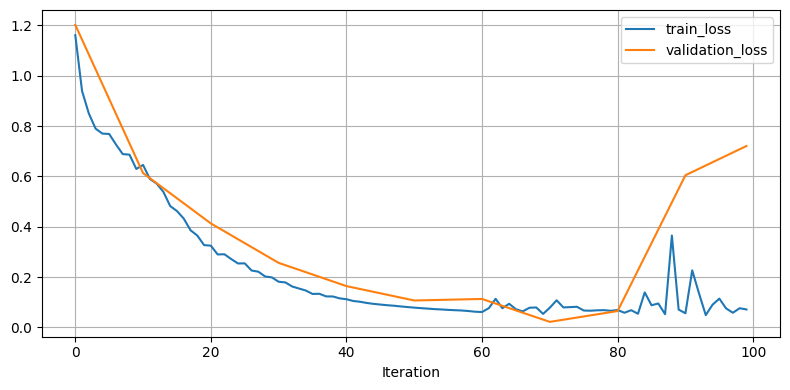

In [15]:
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.set_xlabel('Iteration')

plt.plot(train_losses, label='train_loss')
plt.plot(val_steps, val_losses, label='validation_loss')
fig.tight_layout(); plt.legend(); plt.grid(); plt.legend();

In [16]:
# get cross-entropy losses for test data set:
[F.cross_entropy(model(torch.tensor(x)), torch.tensor(y).view(-1)).item() for x, y in test_split]

[2.8074517072689576e-05,
 8.58739362566194e-05,
 0.1253731090865079,
 0.12061857676953165,
 4.370104938505633e-05,
 0.0031534499842012127,
 0.001568871730816457,
 3.695685163982971e-05,
 0.023455089623284218,
 4.892605960178967e-05]